# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [28]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

**Important: Restart the Kernel at this moment**

## Imports

In [29]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [30]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The first transformation is to transform the data into a Pytorch tensor which would scale pixel values from [0, 255] to [0.0, 1.0], the second transformation normalizes the tensor, Normalize(0.5, 0.5): transforms the pixel values from the range [0.0, 1.0] to [-1.0, 1.0]. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [31]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

2


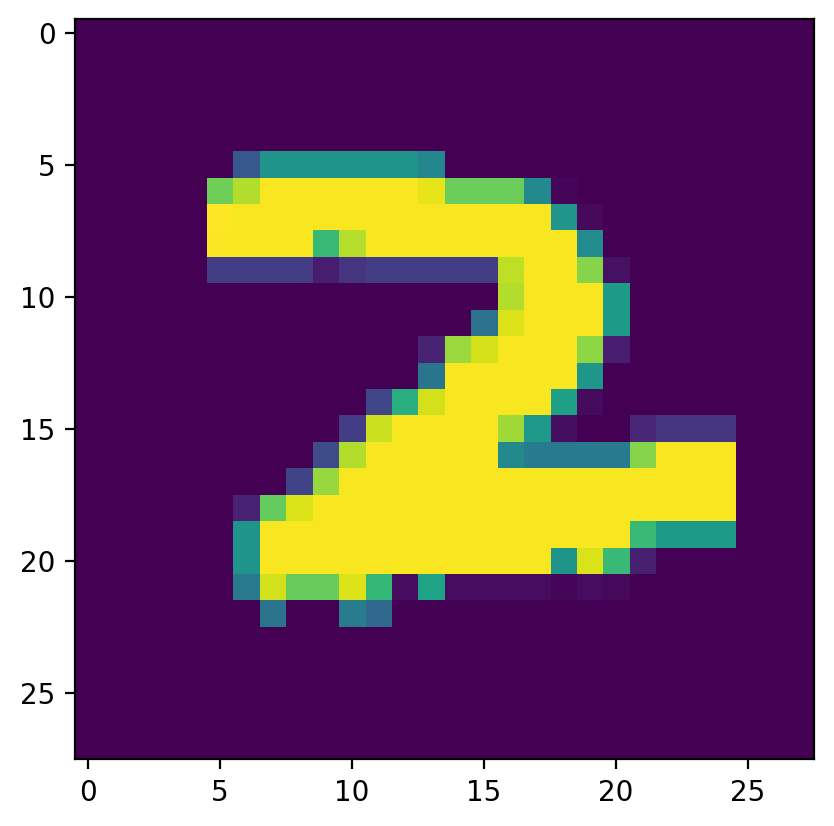

6


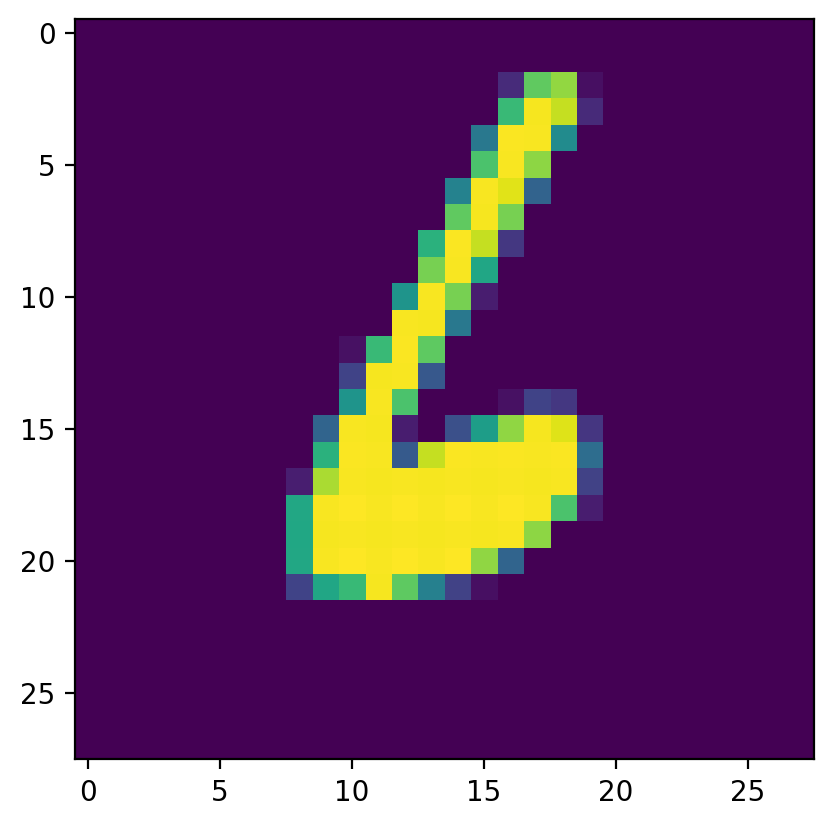

8


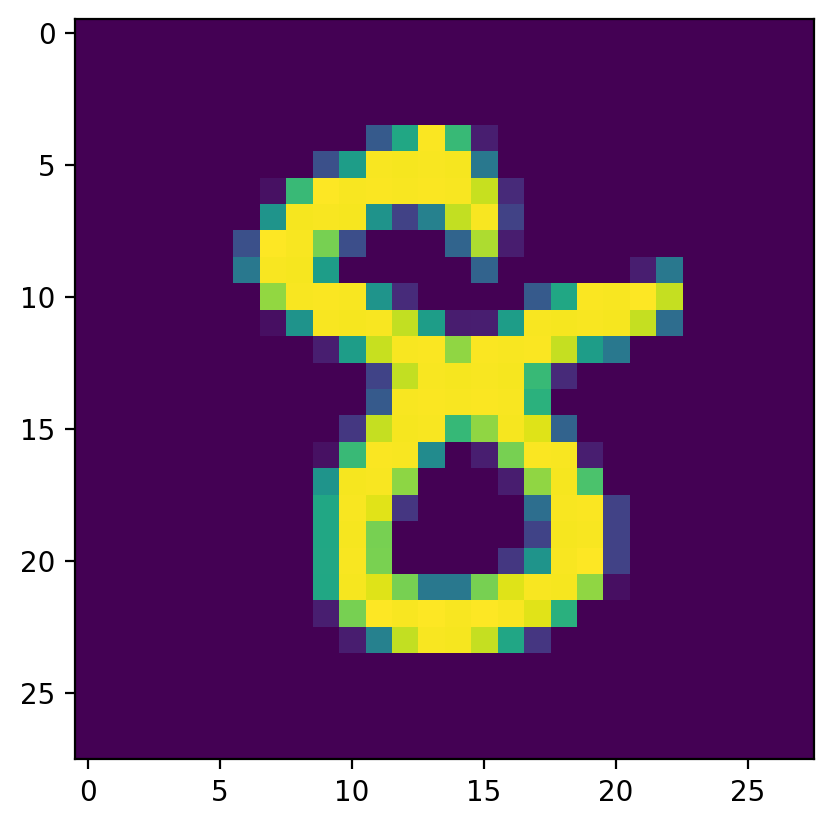

6


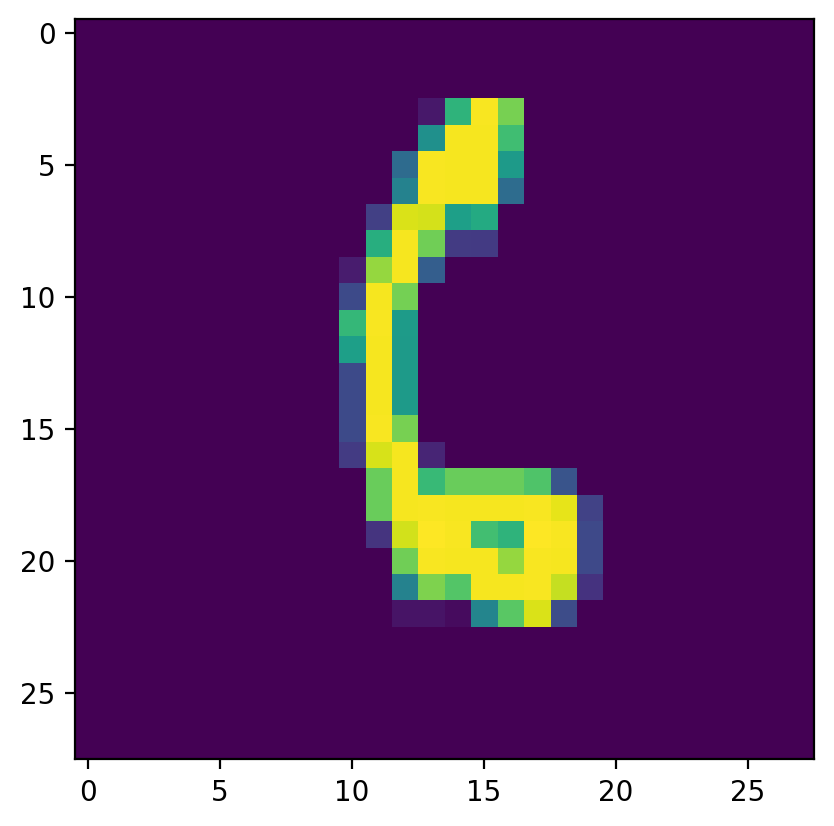

6


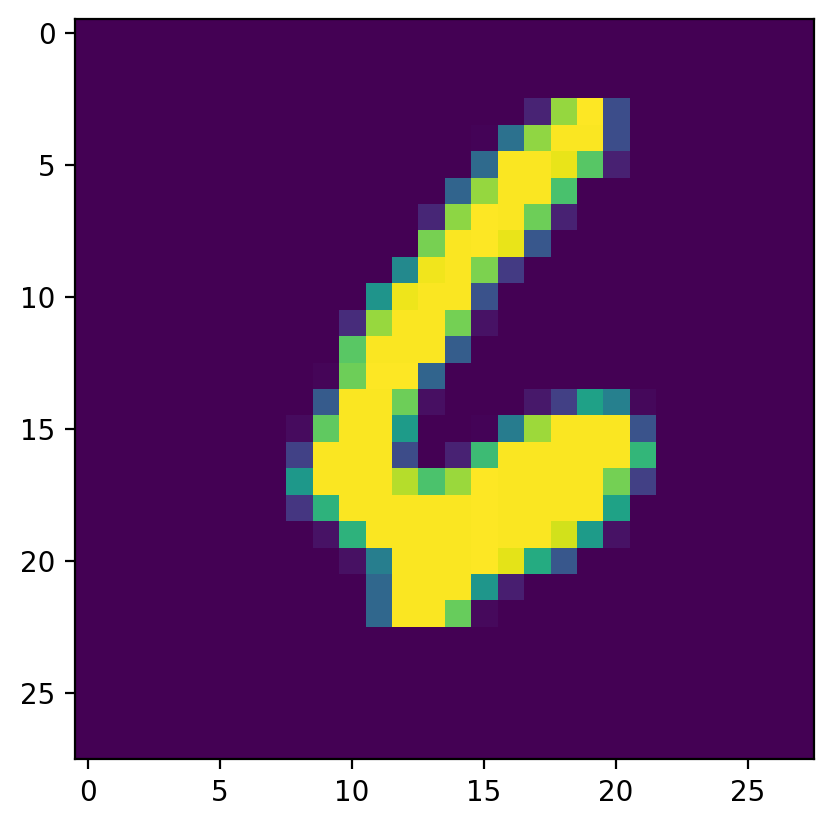

In [32]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [33]:
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [34]:

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 5
train_losses= []
model.to(device)
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

        model.train()

        train_losses.append(running_loss/len(trainloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                )

Training loss: 1.9025210800455576
Epoch: 1/5..  Training Loss: 1.903.. 
Training loss: 0.836497440743548
Epoch: 2/5..  Training Loss: 0.836.. 
Training loss: 0.5220563986630582
Epoch: 3/5..  Training Loss: 0.522.. 
Training loss: 0.4282299214080453
Epoch: 4/5..  Training Loss: 0.428.. 
Training loss: 0.38315405756997656
Epoch: 5/5..  Training Loss: 0.383.. 


Plot the training loss (and validation loss/accuracy, if recorded).

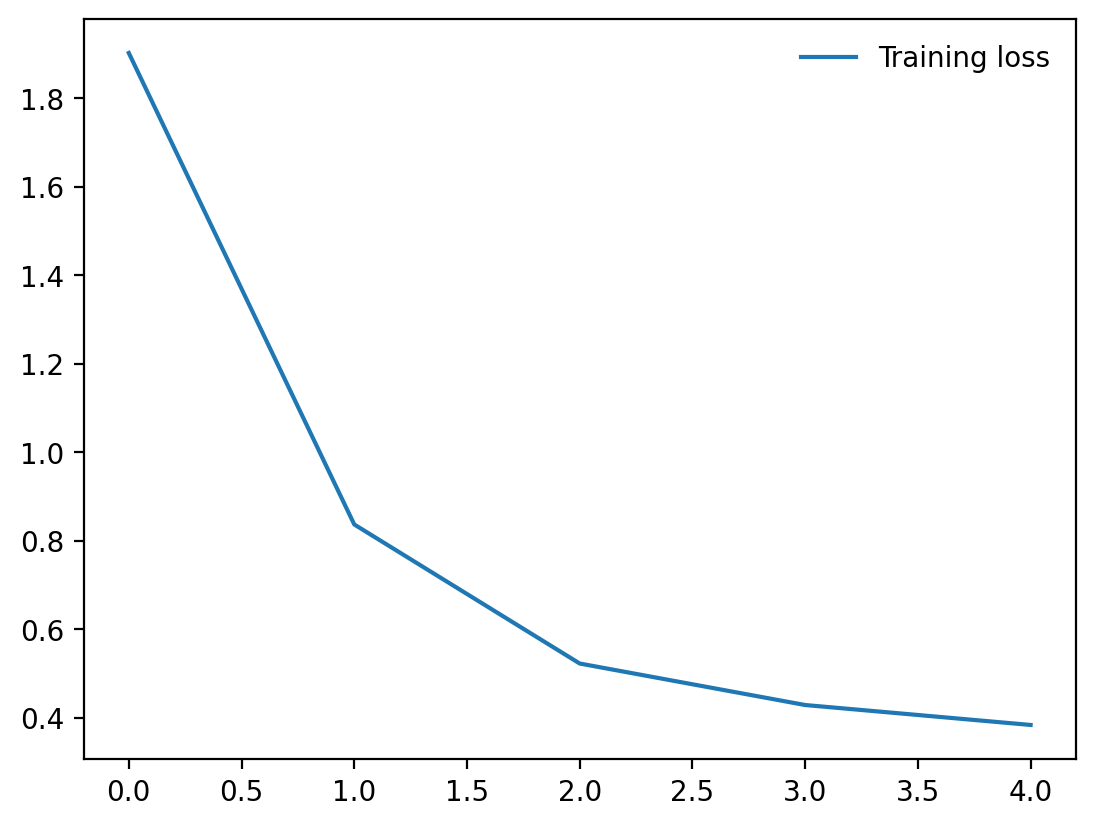

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [37]:
test_loss = 0
accuracy = 0
        
# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()
    with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    print(
                        f"Test loss: {test_loss/len(testloader):.3f}.. "
                        f"Test accuracy: {accuracy/len(testloader):.3f}")
                    

Test loss: 0.002.. Test accuracy: 0.006
Test loss: 0.004.. Test accuracy: 0.012
Test loss: 0.006.. Test accuracy: 0.018
Test loss: 0.008.. Test accuracy: 0.024
Test loss: 0.011.. Test accuracy: 0.029
Test loss: 0.014.. Test accuracy: 0.035
Test loss: 0.016.. Test accuracy: 0.041
Test loss: 0.019.. Test accuracy: 0.046
Test loss: 0.022.. Test accuracy: 0.051
Test loss: 0.025.. Test accuracy: 0.056
Test loss: 0.028.. Test accuracy: 0.062
Test loss: 0.031.. Test accuracy: 0.067
Test loss: 0.032.. Test accuracy: 0.073
Test loss: 0.034.. Test accuracy: 0.079
Test loss: 0.037.. Test accuracy: 0.084
Test loss: 0.039.. Test accuracy: 0.090
Test loss: 0.042.. Test accuracy: 0.096
Test loss: 0.045.. Test accuracy: 0.101
Test loss: 0.048.. Test accuracy: 0.107
Test loss: 0.053.. Test accuracy: 0.111
Test loss: 0.057.. Test accuracy: 0.117
Test loss: 0.059.. Test accuracy: 0.122
Test loss: 0.062.. Test accuracy: 0.128
Test loss: 0.065.. Test accuracy: 0.133
Test loss: 0.068.. Test accuracy: 0.139


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [41]:
optimizer = optim.SGD(model.parameters(), lr=0.005)

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

        model.train()

        train_losses.append(running_loss/len(trainloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                )
        
test_loss = 0
accuracy = 0
        
# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()
    with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    print(
                        f"Test loss: {test_loss/len(testloader):.3f}.. "
                        f"Test accuracy: {accuracy/len(testloader):.3f}")

Training loss: 0.2823525544232143
Epoch: 1/5..  Training Loss: 0.282.. 
Training loss: 0.2705370386494502
Epoch: 2/5..  Training Loss: 0.271.. 
Training loss: 0.2588909530817573
Epoch: 3/5..  Training Loss: 0.259.. 
Training loss: 0.24816809469925316
Epoch: 4/5..  Training Loss: 0.248.. 
Training loss: 0.23788121222321795
Epoch: 5/5..  Training Loss: 0.238.. 
Test loss: 0.001.. Test accuracy: 0.006
Test loss: 0.002.. Test accuracy: 0.012
Test loss: 0.003.. Test accuracy: 0.019
Test loss: 0.004.. Test accuracy: 0.024
Test loss: 0.006.. Test accuracy: 0.030
Test loss: 0.008.. Test accuracy: 0.036
Test loss: 0.010.. Test accuracy: 0.042
Test loss: 0.012.. Test accuracy: 0.047
Test loss: 0.014.. Test accuracy: 0.053
Test loss: 0.016.. Test accuracy: 0.059
Test loss: 0.018.. Test accuracy: 0.065
Test loss: 0.020.. Test accuracy: 0.071
Test loss: 0.021.. Test accuracy: 0.077
Test loss: 0.022.. Test accuracy: 0.083
Test loss: 0.024.. Test accuracy: 0.089
Test loss: 0.026.. Test accuracy: 0.09

## Saving your model
Using `torch.save`, save your model for future loading.

In [43]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')

Our model: 

 Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
) 

The state dict keys: 

 odict_keys(['1.weight', '1.bias', '3.weight', '3.bias', '5.weight', '5.bias'])
